# Both legs push off powerfully, causing imbalance

In [8]:
import os
import cv2
import mediapipe as mp
import numpy as np
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False)

# Paths
videos_dir = "stage3-dataset"  # Directory containing input videos
output_dir = "stage3-keypoints"  # Directory to save keypoints
os.makedirs(output_dir, exist_ok=True)

def normalize_keypoints(keypoints, reference_length):
    """
    Normalize keypoints using a reference length.

    Args:
        keypoints (list): List of keypoints for a single frame.
        reference_length (float): Reference length (e.g., shoulder width) for normalization.

    Returns:
        normalized_keypoints: List of normalized keypoints for a single frame.
    """
    if reference_length == 0:  # Avoid division by zero
        reference_length = 1

    normalized_keypoints = [
        {
            "x": kp["x"] / reference_length,
            "y": kp["y"] / reference_length,
            "z": kp["z"] / reference_length,
            "visibility": kp["visibility"],  # Visibility is not normalized
        }
        for kp in keypoints
    ]
    return normalized_keypoints

def extract_keypoints_with_normalization(frame):
    """
    Extract and normalize keypoints from a single frame.
    """
    h, w, _ = frame.shape
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)
    
    if not result.pose_landmarks:
        return None  # Skip frames where no landmarks are detected

    # Extract keypoints
    keypoints = [
        {"x": lm.x * w, "y": lm.y * h, "z": lm.z * w, "visibility": lm.visibility}
        for lm in result.pose_landmarks.landmark
    ]

    # Calculate reference length (distance between shoulders)
    left_shoulder = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    reference_length = np.sqrt(
        (left_shoulder.x * w - right_shoulder.x * w) ** 2 +
        (left_shoulder.y * h - right_shoulder.y * h) ** 2
    )

    # Normalize keypoints
    normalized_keypoints = normalize_keypoints(keypoints, reference_length)
    return normalized_keypoints

def process_video_with_normalization(video_path, output_path, frame_skip=1):
    """
    Process a video to extract and normalize keypoints and save them as a JSON file.

    Args:
        video_path (str): Path to the video file.
        output_path (str): Path to save keypoints as JSON.
        frame_skip (int): Number of frames to skip between processing.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        return

    frame_count = 0
    keypoints_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames based on frame_skip
        if frame_count % frame_skip == 0:
            normalized_keypoints = extract_keypoints_with_normalization(frame)
            if normalized_keypoints:
                keypoints_data.append({"frame": frame_count, "keypoints": normalized_keypoints})
        
        frame_count += 1

    cap.release()

    # Save keypoints to JSON
    with open(output_path, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

    print(f"Normalized keypoints saved to {output_path}")

# Example Usage: Process videos with normalization and skip every 2 frames
for video_file in os.listdir(videos_dir):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(videos_dir, video_file)
        video_name = os.path.splitext(video_file)[0]
        output_path = os.path.join(output_dir, f"{video_name}_normalized_keypoints.json")
        process_video_with_normalization(video_path, output_path, frame_skip=3)  # Skip every 2 frames

print("Normalized keypoint extraction completed!")

Normalized keypoints saved to stage3-keypoints\user100_brightness_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user100_mirrored_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user100_noise_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user100_original_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user100_rotate_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user101_brightness_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user101_mirrored_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user101_noise_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user101_original_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user101_rotate_normalized_keypoints.json
Normalized keypoints saved to stage3-keypoints\user102_brightness_normalized_keypoints.json
Normalized key

In [9]:
import os
import json
import numpy as np

# Paths
keypoints_dir = "stage3-keypoints"  # Directory with keypoints JSON files
features_dir = "stage3-features"  # Directory to save extracted features
os.makedirs(features_dir, exist_ok=True)

def compute_reference_length(keypoints):
    """
    Compute the reference length (e.g., distance between shoulders) for normalization.
    """
    left_shoulder = keypoints[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder = keypoints[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    reference_length = np.sqrt(
        (left_shoulder["x"] - right_shoulder["x"]) ** 2 +
        (left_shoulder["y"] - right_shoulder["y"]) ** 2
    )
    return reference_length if reference_length > 0 else 1  # Avoid division by zero

def normalize_keypoints(keypoints, reference_length):
    """
    Normalize keypoints using a reference length.
    """
    normalized_keypoints = [
        {
            "x": kp["x"] / reference_length,
            "y": kp["y"] / reference_length,
            "z": kp["z"] / reference_length,
            "visibility": kp["visibility"],  # Visibility is not normalized
        }
        for kp in keypoints
    ]
    return normalized_keypoints

def compute_features(keypoints_sequence):
    """
    Compute velocity and acceleration features from normalized keypoints.

    Args:
        keypoints_sequence (list): List of keypoints for consecutive frames.

    Returns:
        features: Array of features for each frame (velocity, acceleration, etc.).
    """
    normalized_sequences = []
    velocities = []
    accelerations = []

    # Normalize keypoints for each frame
    for frame_data in keypoints_sequence:
        keypoints = frame_data["keypoints"]
        reference_length = compute_reference_length(keypoints)
        normalized_keypoints = normalize_keypoints(keypoints, reference_length)
        normalized_sequences.append(normalized_keypoints)

    # Compute velocity and acceleration
    for i in range(1, len(normalized_sequences)):
        prev_frame = np.array([[kp["x"], kp["y"]] for kp in normalized_sequences[i - 1]])
        curr_frame = np.array([[kp["x"], kp["y"]] for kp in normalized_sequences[i]])

        # Compute velocity (change in position)
        velocity = curr_frame - prev_frame
        velocities.append(velocity)

        if i > 1:
            # Compute acceleration (change in velocity)
            prev_velocity = np.array(velocities[-2])
            acceleration = velocity - prev_velocity
            accelerations.append(acceleration)

    # Pad initial frames with zeros (no velocity/acceleration for the first frame)
    velocities = [np.zeros_like(velocities[0])] + velocities
    accelerations = [np.zeros_like(accelerations[0])] * 2 + accelerations

    return np.array(velocities), np.array(accelerations)

def process_keypoints_file(file_path, output_path):
    """
    Process a single keypoints JSON file to compute features.

    Args:
        file_path (str): Path to the JSON file with keypoints.
        output_path (str): Path to save the computed features.
    """
    with open(file_path, "r") as f:
        keypoints_sequence = json.load(f)

    velocities, accelerations = compute_features(keypoints_sequence)

    # Combine features
    features = {
        "velocities": velocities.tolist(),
        "accelerations": accelerations.tolist()
    }

    # Save features as JSON
    with open(output_path, "w") as f:
        json.dump(features, f, indent=4)

# Process all keypoints JSON files
for keypoints_file in os.listdir(keypoints_dir):
    if keypoints_file.endswith(".json"):
        input_path = os.path.join(keypoints_dir, keypoints_file)
        output_path = os.path.join(features_dir, keypoints_file)
        process_keypoints_file(input_path, output_path)
        print(f"Processed features for {keypoints_file}")

print("Feature extraction with normalization completed!")


Processed features for user100_brightness_normalized_keypoints.json
Processed features for user100_mirrored_normalized_keypoints.json
Processed features for user100_noise_normalized_keypoints.json
Processed features for user100_original_normalized_keypoints.json
Processed features for user100_rotate_normalized_keypoints.json
Processed features for user101_brightness_normalized_keypoints.json
Processed features for user101_mirrored_normalized_keypoints.json
Processed features for user101_noise_normalized_keypoints.json
Processed features for user101_original_normalized_keypoints.json
Processed features for user101_rotate_normalized_keypoints.json
Processed features for user102_brightness_normalized_keypoints.json
Processed features for user102_mirrored_normalized_keypoints.json
Processed features for user102_noise_normalized_keypoints.json
Processed features for user102_original_normalized_keypoints.json
Processed features for user102_rotate_normalized_keypoints.json
Processed features 

In [ ]:
import os
import json

# Paths
keypoints_dir = "stage3-keypoints"  # Directory with keypoints JSON files
features_dir = "stage3-features"  # Directory with features JSON files
output_keypoints_dir = "padded-keypoints"  # Directory to save padded keypoints
output_features_dir = "padded-features"  # Directory to save padded features
os.makedirs(output_keypoints_dir, exist_ok=True)
os.makedirs(output_features_dir, exist_ok=True)


def pad_keyframes(keypoints_sequence, max_length, num_keypoints):
    """
    Pad keyframes to ensure consistent sequence length.
    """
    padding_frame = [{"x": 0.0, "y": 0.0, "z": 0.0, "visibility": 0.0}] * num_keypoints
    while len(keypoints_sequence) < max_length:
        keypoints_sequence.append({"frame": len(keypoints_sequence), "keypoints": padding_frame})
    return keypoints_sequence


def pad_features(features, max_length, num_keypoints):
    """
    Pad velocities and accelerations to ensure consistent sequence length.
    """
    zero_velocity = [[0.0, 0.0]] * num_keypoints
    zero_acceleration = [[0.0, 0.0]] * num_keypoints

    while len(features["velocities"]) < max_length:
        features["velocities"].append(zero_velocity)
    while len(features["accelerations"]) < max_length:
        features["accelerations"].append(zero_acceleration)

    return features


def get_max_length(keypoints_dir):
    """
    Determine the maximum sequence length across all keypoints files.
    """
    max_length = 0
    for file in os.listdir(keypoints_dir):
        if file.endswith(".json"):
            with open(os.path.join(keypoints_dir, file), "r") as f:
                keypoints_sequence = json.load(f)
                max_length = max(max_length, len(keypoints_sequence))
    return max_length


# Compute the maximum sequence length
max_length = get_max_length(keypoints_dir)

# Process all keypoints and features files
for file in os.listdir(keypoints_dir):
    if file.endswith(".json"):
        keypoints_path = os.path.join(keypoints_dir, file)
        features_path = os.path.join(features_dir, file)

        with open(keypoints_path, "r") as kf, open(features_path, "r") as ff:
            keypoints_sequence = json.load(kf)
            features = json.load(ff)

            # Get the number of keypoints from the first frame
            num_keypoints = len(keypoints_sequence[0]["keypoints"]) if keypoints_sequence else 0

            # Pad both keypoints and features
            padded_keypoints = pad_keyframes(keypoints_sequence, max_length, num_keypoints)
            padded_features = pad_features(features, max_length, num_keypoints)

        # Save padded results
        padded_keypoints_path = os.path.join(output_keypoints_dir, file)
        padded_features_path = os.path.join(output_features_dir, file)
        with open(padded_keypoints_path, "w") as kf, open(padded_features_path, "w") as ff:
            json.dump(padded_keypoints, kf, indent=4)
            json.dump(padded_features, ff, indent=4)

print("Padding completed for both keypoints and features.")


In [2]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
padded_features_dir = "padded-features"
labels_file = "stage3-dataset.csv"

# Load labels
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['user'], labels_df['label']))

# Load and prepare dataset
def load_dataset(features_dir, label_mapping):
    sequences = []
    labels = []

    for file in os.listdir(features_dir):
        if file.endswith(".json"):
            user_id = os.path.splitext(file)[0]
            
            # Skip if the user_id doesn't have a label
            if user_id not in label_mapping:
                print(f"No label for {user_id}. Skipping...")
                continue
            
            label = label_mapping[user_id]
            file_path = os.path.join(features_dir, file)
            
            # Load features
            with open(file_path, "r") as f:
                features = json.load(f)
            
            # Combine velocities and accelerations into a single array
            velocities = np.array(features["velocities"])
            accelerations = np.array(features["accelerations"])
            combined_features = np.concatenate([velocities, accelerations], axis=-1)

            # Append to dataset
            sequences.append(combined_features)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# Load the dataset
X, y = load_dataset(padded_features_dir, label_mapping)

# Determine the maximum sequence length
sequence_length = max(seq.shape[0] for seq in X)

# Pad sequences to ensure consistent length
padded_X = []
for i, seq in enumerate(X):
    try:
        # Get the number of features (considering the third dimension)
        num_features = seq.shape[1]
        extra_dimension = seq.shape[2]

        # Pad the sequence
        padded_seq = np.pad(
            seq,
            ((0, sequence_length - seq.shape[0]), (0, 0), (0, 0)),  # Pad along the first axis only
            mode='constant',
            constant_values=0
        )
        padded_X.append(padded_seq)

    except Exception as e:
        print(f"Error at sequence {i} with shape {seq.shape}: {e}")
        continue  # Skip problematic sequences

# Convert to numpy array
X = np.array(padded_X)

# Validate dimensions after padding
print(f"Padded X shape: {X.shape}")




# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}")



Padded X shape: (110, 61, 33, 4)
Train set: (77, 61, 33, 4), Validation set: (33, 61, 33, 4)


In [4]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (batch_size, sequence_length, feature_dim)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)          # (batch_size, sequence_length, feature_dim)

print(f"Reshaped Train set: {X_train.shape}, Validation set: {X_val.shape}")


Reshaped Train set: (77, 61, 132), Validation set: (33, 61, 132)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Transformer Model Definition
def create_transformer_model(sequence_length, feature_dim):
    inputs = layers.Input(shape=(sequence_length, feature_dim))
    x = layers.LayerNormalization()(inputs)

    # Transformer Encoder
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)
    
    # Feed-forward layer
    ff_output = layers.Dense(64, activation='relu')(x)
    ff_output = layers.Dense(feature_dim)(ff_output)  # Match dimensions for residual connection
    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization()(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output

    model = models.Model(inputs, outputs)
    return model

# Model Configuration
sequence_length = X_train.shape[1]  # Sequence length (e.g., 61)
feature_dim = X_train.shape[2]  # Number of features per frame (e.g., 33 * 4)
model = create_transformer_model(sequence_length, feature_dim)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Handle class imbalance
   #  callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the model
model.save("stage3-transformer.keras")
print("Model training complete and saved as 'stage3-transformer.keras'")


Class weights: {0: 0.7857142857142857, 1: 1.375}
Epoch 1/200
5/5 [==============================] - 2s 146ms/step - loss: 0.7715 - mae: 0.4961 - val_loss: 0.6644 - val_mae: 0.4744
Epoch 2/200
5/5 [==============================] - 0s 51ms/step - loss: 0.6715 - mae: 0.4695 - val_loss: 0.6573 - val_mae: 0.4757
Epoch 3/200
5/5 [==============================] - 0s 53ms/step - loss: 0.6053 - mae: 0.4212 - val_loss: 0.6886 - val_mae: 0.4889
Epoch 4/200
5/5 [==============================] - 0s 60ms/step - loss: 0.5668 - mae: 0.4042 - val_loss: 0.7025 - val_mae: 0.4889
Epoch 5/200
5/5 [==============================] - 0s 60ms/step - loss: 0.5385 - mae: 0.4000 - val_loss: 0.7118 - val_mae: 0.4875
Epoch 6/200
5/5 [==============================] - 0s 62ms/step - loss: 0.5356 - mae: 0.3888 - val_loss: 0.6710 - val_mae: 0.4597
Epoch 7/200
5/5 [==============================] - 0s 76ms/step - loss: 0.5353 - mae: 0.3640 - val_loss: 0.6187 - val_mae: 0.4310
Epoch 8/200
5/5 [=======================

In [5]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Define threshold
threshold = 0.5  # Predictions above this are classified as 1 (incorrect), below as 0 (correct)

# Load the trained model
model = load_model("stage3-transformer.keras")

# Predict on the validation set
y_pred = model.predict(X_val).flatten()  # Flatten predictions for simplicity

# Apply threshold to classify
y_classified = [1 if pred > threshold else 0 for pred in y_pred]

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
class_report = classification_report(y_val, y_classified, target_names=["Correct", "Incorrect"])
print("Classification Report:")
print(class_report)


2/2 [==============================] - 1s 39ms/step
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           0     1.277181e-08                0
1           0     7.341225e-08                0
2           1     8.401749e-01                1
3           0     1.791547e-04                0
4           0     1.131109e-05                0
Accuracy: 0.88
Confusion Matrix:
[[20  1]
 [ 3  9]]
Classification Report:
              precision    recall  f1-score   support

     Correct       0.87      0.95      0.91        21
   Incorrect       0.90      0.75      0.82        12

    accuracy                           0.88        33
   macro avg       0.88      0.85      0.86        33
weighted avg       0.88      0.88      0.88        33



2/2 [==============================] - 0s 17ms/step
[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


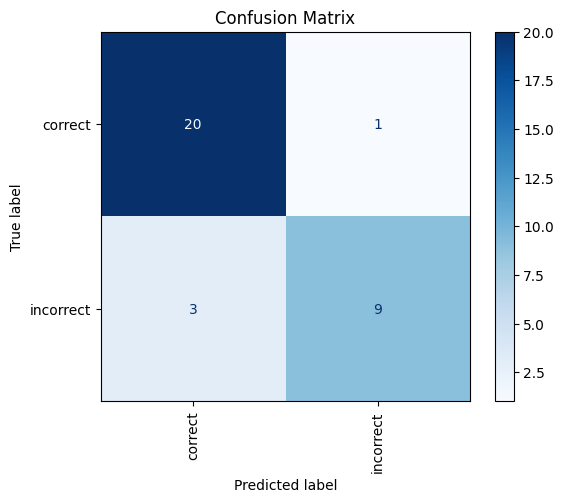

Accuracy: 0.88


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
# threshold = 0.005  # Adjust this value to experiment with different thresholds
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)


# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")
